In [6]:
import napari
import tifffile
import numpy as np
from skimage import measure


In [7]:

# Load anatomy images 

sum_elastic_corrected_path = r'\\tungsten-nas.fmi.ch\tungsten\scratch\gfriedri\montruth\2P_RawData\2022-04-26\f3\trials\processed\sum_elastic_corrected_trials_20220426_RM0008_130hpf_fP1_f3.tif'
masks_path = r"\\tungsten-nas.fmi.ch\tungsten\scratch\gfriedri\montruth\2P_RawData\2022-04-26\f3\trials\masks\masks_20220426_RM0008_130hpf_fP1_f3_cp_-3-ft_0-st_0.01-resample_True-augment_False.tif"
images_stack = tifffile.imread(sum_elastic_corrected_path)
masks = tifffile.imread(masks_path)
print(images_stack.shape)
print(masks.shape)



(8, 24, 256, 512)
(8, 24, 256, 512)


In [8]:
viewer = napari.Viewer()
viewer.add_image(images_stack, name='sum_elastic_corrected_trials')
viewer.add_labels(masks, name= 'masks', opacity=0.3)

<Labels layer 'masks' at 0x1edc8c886a0>

In [9]:
################ with warped stack 

In [10]:
warped_stack = tifffile.imread( r'\\tungsten-nas.fmi.ch\tungsten\scratch\gfriedri\montruth\2P_RawData\2022-04-26\f3\trials\processed\final_warped_lm_stack_bw_flipped_to_lm_plane06.tif')
warped_stack_mask = tifffile.imread(r'D:\montruth\proofreading\final_warped_lm_stack_bw_flipped_to_lm_plane06_cp_masks.tif')
flipped_images_stack = np.flip(images_stack, axis=-1)

In [11]:
viewer = napari.Viewer()
viewer.add_image(warped_stack, name='final_warped_lm_stack', blending='additive')
viewer.add_labels(warped_stack_mask, name='final_warped_lm_stack_mask', blending='additive')
viewer.add_image(flipped_images_stack[6], name='flipped_images_stack', blending='additive')

D:\montruth\PycharmProjects\samplePy\.venv\lib\site-packages\napari\plugins\_plugin_manager.py:555: UserWarning: Plugin 'napari_skimage_regionprops2' has already registered a function widget 'duplicate current frame' which has now been overwritten
  warn(message=warn_message)
D:\montruth\PycharmProjects\samplePy\.venv\lib\site-packages\napari\plugins\_plugin_manager.py:555: UserWarning: Plugin 'napari-animated-gif-io' has already registered a function widget 'save as animated gif' which has now been overwritten
  warn(message=warn_message)


<Image layer 'flipped_images_stack' at 0x1edecfde6e0>

In [12]:
from scipy import ndimage
gaussian_warped_stack = ndimage.gaussian_filter(warped_stack, sigma=1)
viewer.add_image(gaussian_warped_stack, blending = 'additive')

<Image layer 'gaussian_warped_stack' at 0x1edc8c8a080>

In [13]:
# find position of image in warped stack through correlation 
from skimage.registration import phase_cross_correlation
from skimage.exposure import match_histograms
from matplotlib import pyplot as plt

# Create a correlation matrix

n_flipped = len(flipped_images_stack[6])
n_warped = len(warped_stack)
corr_matrix = np.zeros((n_flipped, n_warped))

for i, image in enumerate(flipped_images_stack[6]):
    for j, slice in enumerate(gaussian_warped_stack): 
        eq_image = match_histograms(image, slice)
        shift, error, phasediff = phase_cross_correlation(eq_image, slice)
        corr = np.corrcoef(image.flatten(), slice.flatten())[0,1]
        corr_matrix[i,j] = corr  # or phasediff



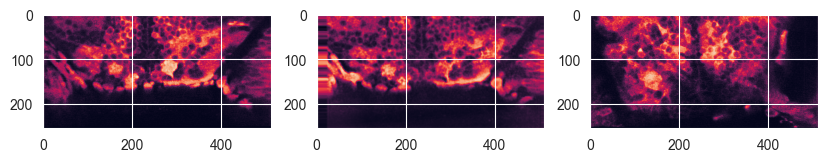

In [40]:
img1 = flipped_images_stack[6,14]
img2 = gaussian_warped_stack[14]
img3 = flipped_images_stack[2,14]
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
axs[0].imshow(match_histograms(img1, img2))
axs[1].imshow(img2)
axs[2].imshow(match_histograms(img3, img2))



In [45]:
ssi12 = ssim(img1, img2, data_range=1)
print(ssi12)

ssi13 = ssim(img1, img3, data_range=1)
print(ssi13)

ssi23 = ssim(img2, img3, data_range=1)
print(ssi23)

5.348629511391261e-05
-12749151.960325377
-2.548244771282287e-13


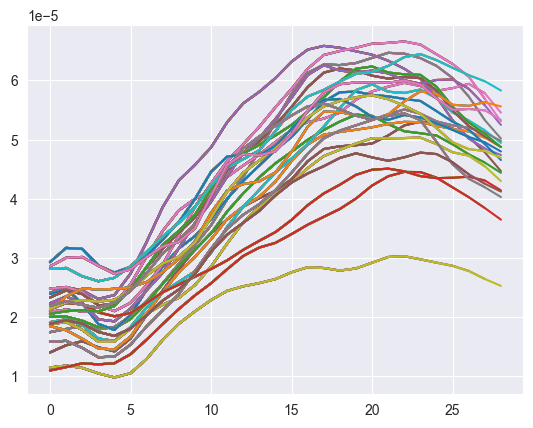

In [64]:
img_pos = []
for img in flipped_images_stack[6]:
    ssis = []
    for gaussian_warped_slice in gaussian_warped_stack:
        ssi = ssim(img, gaussian_warped_slice, data_range=1)
        ssis.append(ssi)
        plt.plot(ssis)
    img_pos.append(np.argmax(ssis))
    



In [65]:
flipped_images_mask = warped_stack_mask[img_pos]
print(flipped_images_mask.shape)

(24, 256, 512)


In [67]:
viewer = napari.Viewer()
viewer.add_image(flipped_images_stack[6], name= 'flipped_images_stack', blending='additive')
viewer.add_labels(flipped_images_mask, name= 'flipped_images_mask', blending='additive')

D:\montruth\PycharmProjects\samplePy\.venv\lib\site-packages\napari\plugins\_plugin_manager.py:555: UserWarning: Plugin 'napari_skimage_regionprops2' has already registered a function widget 'duplicate current frame' which has now been overwritten
  warn(message=warn_message)
D:\montruth\PycharmProjects\samplePy\.venv\lib\site-packages\napari\plugins\_plugin_manager.py:555: UserWarning: Plugin 'napari-animated-gif-io' has already registered a function widget 'save as animated gif' which has now been overwritten
  warn(message=warn_message)


<Labels layer 'flipped_images_mask' at 0x1ed8ac82020>

In [55]:
from sklearn.metrics import mutual_info_score

def compute_mutual_information(img1, img2):
    hist_2d, _, _ = np.histogram2d(img1.flatten(), 
                                  img2.flatten(), 
                                  bins=20)
    return mutual_info_score(None, None, contingency=hist_2d)

corr_matrix = np.zeros((n_flipped, n_warped))
for i, image in enumerate(norm_flipped_images_stack[6]):
    for j, slice in enumerate(norm_warped_stack):
        mi = compute_mutual_information(image, slice)
        corr_matrix[i, j] = mi


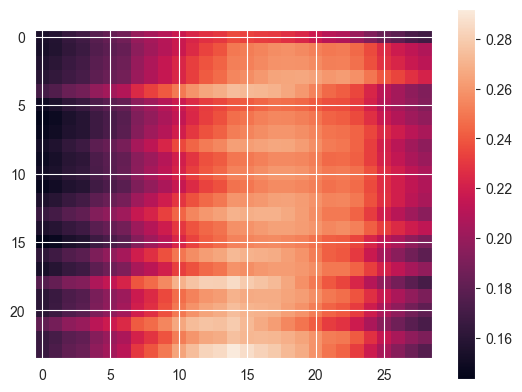

In [56]:

plt.imshow(corr_matrix)
plt.colorbar()

In [68]:
image_pos = np.argmax(corr_matrix, axis=1)

In [69]:
flipped_images_mask = warped_stack_mask[img_pos]
print(flipped_images_mask.shape)
viewer = napari.Viewer()
viewer.add_image(flipped_images_stack[6], name='flipped_images_stack', blending='additive')
viewer.add_labels(flipped_images_mask, name='flipped_images_mask', blending='additive')

(24, 256, 512)


D:\montruth\PycharmProjects\samplePy\.venv\lib\site-packages\napari\plugins\_plugin_manager.py:555: UserWarning: Plugin 'napari_skimage_regionprops2' has already registered a function widget 'duplicate current frame' which has now been overwritten
  warn(message=warn_message)
D:\montruth\PycharmProjects\samplePy\.venv\lib\site-packages\napari\plugins\_plugin_manager.py:555: UserWarning: Plugin 'napari-animated-gif-io' has already registered a function widget 'save as animated gif' which has now been overwritten
  warn(message=warn_message)


<Labels layer 'flipped_images_mask' at 0x1ee0747f220>

In [70]:
image_pos

array([14, 18, 18, 19, 14, 17, 17, 17, 17, 18, 17, 18, 18, 14, 18, 17, 14,
       18, 14, 14, 14, 14, 14, 14], dtype=int64)

In [18]:
image_pos

array([14, 20, 19, 20, 15, 19, 19, 19, 18, 19, 19, 19, 19, 18, 20, 18, 15,
       19, 14, 17, 15, 12, 17, 15], dtype=int64)

In [60]:
resampled_warped_stack = np.zeros_like(flipped_images_stack[6])
for i, pos in enumerate(image_pos):
    resampled_warped_stack[i] = warped_stack[pos]

In [61]:
viewer.add_image(resampled_warped_stack)

<Image layer 'resampled_warped_stack' at 0x1ee0aa60280>

In [62]:
resampled_warped_stack_mask = np.zeros_like(flipped_images_stack[6], dtype=int)
for i, pos in enumerate(image_pos):
    resampled_warped_stack_mask[i] = warped_stack_mask[pos]
viewer.add_labels(resampled_warped_stack_mask, blending = "additive")

<Labels layer 'resampled_warped_stack_mask' at 0x1ee0aa62e90>

In [22]:
from skimage.exposure import cumulative_distribution
import numpy as np

def match_histograms_normalized(source, reference):
    # Normalize images to 0-255 range
    source_norm = ((source - source.min()) * 255 / 
                  (source.max() - source.min())).astype(np.uint8)
    reference_norm = ((reference - reference.min()) * 255 / 
                     (reference.max() - reference.min())).astype(np.uint8)
    
    # Calculate CDFs
    src_cdf, _ = cumulative_distribution(source_norm)
    ref_cdf, _ = cumulative_distribution(reference_norm)
    
    # Create lookup table
    lookup_table = np.interp(src_cdf, ref_cdf, np.arange(256))
    
    # Apply lookup table
    return lookup_table[source_norm]

# Create output array for matched images
matched_flipped_images_stack = np.zeros_like(flipped_images_stack)

# Apply histogram matching for each slice
for i in range(len(flipped_images_stack)):
    for j in range(flipped_images_stack.shape[1]):
        matched_flipped_images_stack[i,j] = match_histograms_normalized(
            flipped_images_stack[i,j], 
            warped_stack[image_pos[i]]
        )


In [23]:
viewer.add_image(flipped_images_stack)
viewer.add_image(warped_stack)
viewer.add_image(matched_flipped_images_stack)

<Image layer 'matched_flipped_images_stack' at 0x1edeff60e80>

In [24]:
# Create output array for matched images
matched_warped_stack = np.zeros_like(warped_stack)

# Apply histogram matching for each slice
for i in range(len(warped_stack)):
    # Match each warped image to corresponding flipped image based on image_pos
    matched_warped_stack[i] = match_histograms_normalized(
        warped_stack[i],
        flipped_images_stack[0,image_pos]  # Reference image should be from flipped_images_stack
    )


In [25]:
viewer.add_image(matched_warped_stack)

<Image layer 'matched_warped_stack' at 0x1edfb58f490>

In [26]:
from skimage.exposure import equalize_adapthist

# Process the whole stack
clahe_stack = np.zeros_like(warped_stack)
for i in range(len(warped_stack)):
    for j in range(warped_stack.shape[1]):
        clahe_stack[i,j] = equalize_adapthist(
            warped_stack[i,j],
            kernel_size=None,  # defaults to image_width/8 x image_height/8
            clip_limit=0.01,   # controls contrast enhancement
            nbins=256         # number of histogram bins
        )


In [27]:
viewer.add_image(clahe_stack)

<Image layer 'clahe_stack' at 0x1ed8013cd00>

In [28]:
import numpy as np
from skimage.exposure import equalize_adapthist

# 1. Flatten the stack
flattened = warped_stack.flatten()

# 2. Reshape to 2D array where each row is a slice
reshaped = flattened.reshape(warped_stack.shape[0], -1)

# 3. Apply equalization to all slices at once
equalized = np.array([equalize_adapthist(slice) for slice in reshaped])

# 4. Reconstruct the stack with original dimensions
reconstructed = equalized.reshape(warped_stack.shape)


In [29]:
viewer.add_image(reconstructed)

<Image layer 'reconstructed' at 0x1ed8201c220>

In [30]:
# find position of image in warped stack through correlation 

# Create a correlation matrix

n_flipped = len(flipped_images_stack[6])
n_warped = len(reconstructed)
corr_matrix = np.zeros((n_flipped, n_warped))

for i, image in enumerate(flipped_images_stack[6]):
    for j, slice in enumerate(reconstructed): 
        eq_image = match_histograms(image, slice)
        shift, error, phasediff = phase_cross_correlation(eq_image, slice)
        corr = np.corrcoef(image.flatten(), slice.flatten())[0,1]
        corr_matrix[i,j] = corr  # or phasediff

# Now you have a matrix where each element [i,j] represents 
# the correlation between flipped_image[i] and warped_slice[j]


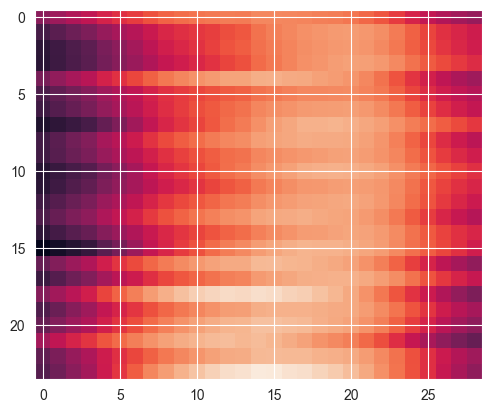

In [31]:
plt.imshow(corr_matrix)

In [32]:
import numpy as np
from skimage.exposure import equalize_adapthist

def equalize_adapthist_stack(stack):
    # 1. Normalize the stack to [-1,1] range
    stack_normalized = (stack - stack.min()) / (stack.max() - stack.min())
    
    # 2. Flatten and reshape
    flattened = stack_normalized.flatten()
    reshaped = flattened.reshape(stack.shape[0], -1)
    
    # 3. Apply equalization
    equalized = np.array([equalize_adapthist(slice, 
                                           kernel_size=None,
                                           clip_limit=0.01,
                                           nbins=256) for slice in reshaped])
    
    # 4. Reconstruct the stack
    reconstructed = equalized.reshape(stack.shape)
    
    return reconstructed

def normalize_stack(stack):
    # 1. Normalize the stack to [-1,1] range
    stack_normalized = (stack - stack.min()) / (stack.max() - stack.min())
        # 3. Apply equalization
    equalized = np.array([equalize_adapthist(slice) for slice in stack_normalized])
    return equalized

eq_flipped_images_stack = equalize_adapthist_stack(flipped_images_stack)
eq_warped_stack = equalize_adapthist_stack(warped_stack)

norm_flipped_images_stack = normalize_stack(flipped_images_stack)
norm_warped_stack = normalize_stack(warped_stack)

In [33]:
viewer = napari.Viewer()
viewer.add_image(flipped_images_stack)
viewer.add_image(warped_stack)
viewer.add_image(eq_flipped_images_stack)
viewer.add_image(eq_warped_stack)
viewer.add_image(norm_flipped_images_stack)
viewer.add_image(norm_warped_stack)

D:\montruth\PycharmProjects\samplePy\.venv\lib\site-packages\napari\plugins\_plugin_manager.py:555: UserWarning: Plugin 'napari_skimage_regionprops2' has already registered a function widget 'duplicate current frame' which has now been overwritten
  warn(message=warn_message)
D:\montruth\PycharmProjects\samplePy\.venv\lib\site-packages\napari\plugins\_plugin_manager.py:555: UserWarning: Plugin 'napari-animated-gif-io' has already registered a function widget 'save as animated gif' which has now been overwritten
  warn(message=warn_message)


<Image layer 'norm_warped_stack' at 0x1ed88665510>

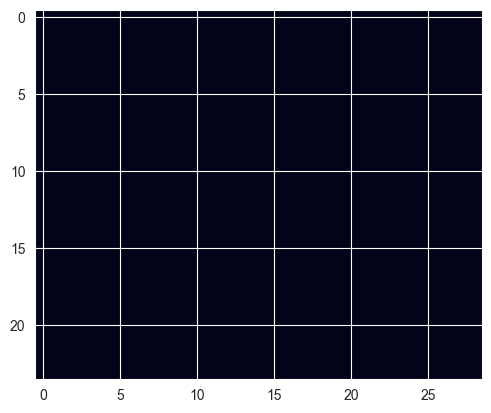

In [35]:
from skimage.metrics import structural_similarity as ssim

# Create a correlation matrix

corr_matrix = np.zeros((n_flipped, n_warped))

for i, image in enumerate(norm_flipped_images_stack[6]):
    for j, slice in enumerate(norm_warped_stack):
        eq_image = match_histograms(image, slice)
        # shift, error, phasediff = phase_cross_correlation(eq_image, slice)
        # corr = np.corrcoef(image.flatten(), slice.flatten())[0, 1]
        similarity = ssim(eq_image, slice, data_range=1.0)
        corr_matrix[i, j] = similarity
        
        corr_matrix[i, j] = corr  # or phasediff

# Now you have a matrix where each element [i,j] represents 
# the correlation between flipped_image[i] and warped_slice[j]

plt.imshow(corr_matrix)

In [ ]:
image_pos = np.argmax(corr_matrix, axis=1)
resampled_flipped_images_stack = np.zeros_like(norm_flipped_images_stack[6])
for i, pos in enumerate(image_pos):
    resampled_flipped_images_stack[i] = norm_warped_stack[pos]
viewer.add_image(resampled_warped_stack)

In [ ]:
np.mean(image_pos)

In [ ]:
len(warped_stack)//2

In [ ]:
np.std(image_pos)

In [ ]:
np.max(image_pos)

In [ ]:
np.min(image_pos)

In [ ]:
ordered_flipped_stack_mask = np.zeros_like(flipped_images_stack[6],dtype=int)
ordered_flipped_images_stack = np.zeros_like(flipped_images_stack[6])
order_pos = np.sort(image_pos)
print(order_pos)

In [ ]:
order_ids =  np.argsort(image_pos)
print(order_ids)

In [ ]:
ordered_flipped_images_stack.shape[0]

In [ ]:
for i in range(ordered_flipped_images_stack.shape[0]):
    ordered_flipped_images_stack[i] = flipped_images_stack[6,order_ids[i]]
    ordered_flipped_stack_mask[i] = warped_stack_mask[order_pos[i]]


In [ ]:
ordered_flipped_stack_mask

In [ ]:
viewer.add_labels(ordered_flipped_stack_mask, blending = "additive")
viewer.add_image(ordered_flipped_images_stack, blending = "additive")

In [ ]:
viewer.add_image(ordered_flipped_images_stack[0], blending = "additive", colormap="orange")
viewer.add_image(ordered_flipped_images_stack[-1], blending = "additive", colormap="blue")

In [ ]:
viewer.add_image(flipped_images_stack, blending = "additive", colormap="orange")
viewer.add_image(mask, blending = "additive", colormap="blue")

In [ ]:
viewer = napari.Viewer()
viewer.add_labels(ordered_flipped_stack_mask, blending = "additive")


In [ ]:
import skimage.io as iio
import skimage.transform as ski_transform
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity

def order_images(images):
    """
    Orders images based on similarity without warping.
    """
    
    # Basic similarity metric (you can replace with more sophisticated methods)
    def image_similarity(img1, img2):
        img1_resized = ski_transform.resize(img1, (img2.shape[0], img2.shape[1]))
        return np.sum((img1_resized - img2)**2)
    

    # Create a similarity matrix
    n = len(images)
    similarity_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i + 1, n):
            similarity_matrix[i, j] = structural_similarity(images[i], images[j], data_range=1.0)
            similarity_matrix[j, i] = similarity_matrix[i, j]

    # Find the best order (simplistic approach)
    order = np.argsort([sum(similarity_matrix[i]) for i in range(n)])
    return order, similarity_matrix

# Example Usage

ordered_indices, similarity_matrix = order_images(flipped_images_stack[6, :,50:150,250:350])
print(ordered_indices)


In [ ]:

# Plot the ordered similarity matrix
plt.figure(figsize=(10, 10))
plt.imshow(similarity_matrix)
plt.colorbar()

In [ ]:


# Plot the ordered similarity matrix
plt.figure(figsize=(10, 10))
plt.imshow(similarity_matrix[ordered_indices][:, ordered_indices])

plt.colorbar()


In [ ]:
similarity_matrix.shape

In [ ]:
print(ordered_indices)

In [ ]:

print(ordered_indices)


In [ ]:
ordered_images = flipped_images_stack[6,ordered_indices]
viewer.add_image(ordered_images)

In [ ]:
viewer.add_image(flipped_images_stack[6])

In [94]:
###### Using LM mask from EM warped stack
from scripts.utils.image_utils import warp_stack_to_plane, load_tiff_as_hyperstack
from skimage.transform import SimilarityTransform


lm_plane = flipped_images_stack[6,-1]

lm_stack = load_tiff_as_hyperstack(r"\\tungsten-nas.fmi.ch\tungsten\scratch\gfriedri\montruth\2P_RawData\2022-04-26\f3\anatomy\processed\grayscale_flipped_upsampled_20220426_RM0008_130hpf_fP1_f3_anatomyGFRF_001_.tif")[:,1]
print(lm_stack.shape)

lm_stack_mask = tifffile.imread(r'\\tungsten-nas.fmi.ch\tungsten\scratch\gfriedri\montruth\2P_RawData\2022-04-26\f3\clem\em_stack_warped_fov_lm_res_lm_cp_masks.tif')
print(lm_stack_mask.shape)

tform_plane2stack = np.load(r'\\tungsten-nas.fmi.ch\tungsten\scratch\gfriedri\montruth\2P_RawData\2022-04-26\f3\trials\processed\registration_tform_lm_plane06_lm_stack_bw_.npy')
print(tform_plane2stack)
tform = SimilarityTransform(matrix=tform_plane2stack)


\\tungsten-nas.fmi.ch\tungsten\scratch\gfriedri\montruth\2P_RawData\2022-04-26\f3\anatomy\processed\grayscale_flipped_upsampled_20220426_RM0008_130hpf_fP1_f3_anatomyGFRF_001_.tif loaded. Shape: (375, 2, 512, 512)
(375, 512, 512)
(375, 512, 512)
[[ 1.04880912e+00 -1.74180590e-01 -1.64465699e-02  5.17110227e+01]
 [ 1.74191201e-01  1.04893609e+00 -6.68014385e-04  1.33170895e+02]
 [ 1.63338027e-02 -2.03538536e-03  1.06317402e+00 -2.28118549e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [95]:
thickness = 10
t_lm_stack = warp_stack_to_plane(lm_stack, lm_plane, tform, thickness)
t_lm_stack_mask = warp_stack_to_plane(lm_stack_mask, lm_plane, tform, thickness).astype(np.int32)


t_lm_stack_slice = warp_stack_to_plane(lm_stack, lm_plane, tform, 3)
t_lm_stack_mask_slice = warp_stack_to_plane(lm_stack_mask, lm_plane, tform, 3).astype(np.int32)


In [96]:
viewer = napari.Viewer()
viewer.add_image(t_lm_stack)
viewer.add_labels(t_lm_stack_mask, blending = "additive")

D:\montruth\PycharmProjects\samplePy\.venv\lib\site-packages\napari\plugins\_plugin_manager.py:555: UserWarning: Plugin 'napari_skimage_regionprops2' has already registered a function widget 'duplicate current frame' which has now been overwritten
  warn(message=warn_message)
D:\montruth\PycharmProjects\samplePy\.venv\lib\site-packages\napari\plugins\_plugin_manager.py:555: UserWarning: Plugin 'napari-animated-gif-io' has already registered a function widget 'save as animated gif' which has now been overwritten
  warn(message=warn_message)


<Labels layer 't_lm_stack_mask' at 0x1ee25845510>

In [97]:
viewer.add_image(t_lm_stack_slice)
viewer.add_labels(t_lm_stack_mask_slice, blending = "additive")

<Labels layer 't_lm_stack_mask_slice' at 0x1ee24d3ef50>

In [98]:
viewer.add_image(lm_plane)

<Image layer 'lm_plane' at 0x1ee2c3ea200>